Saved CSV: decoded_bits.csv
Saved TXT: decoded_bits.txt

Decoded bits (first 200):
 1100111100010101101110111


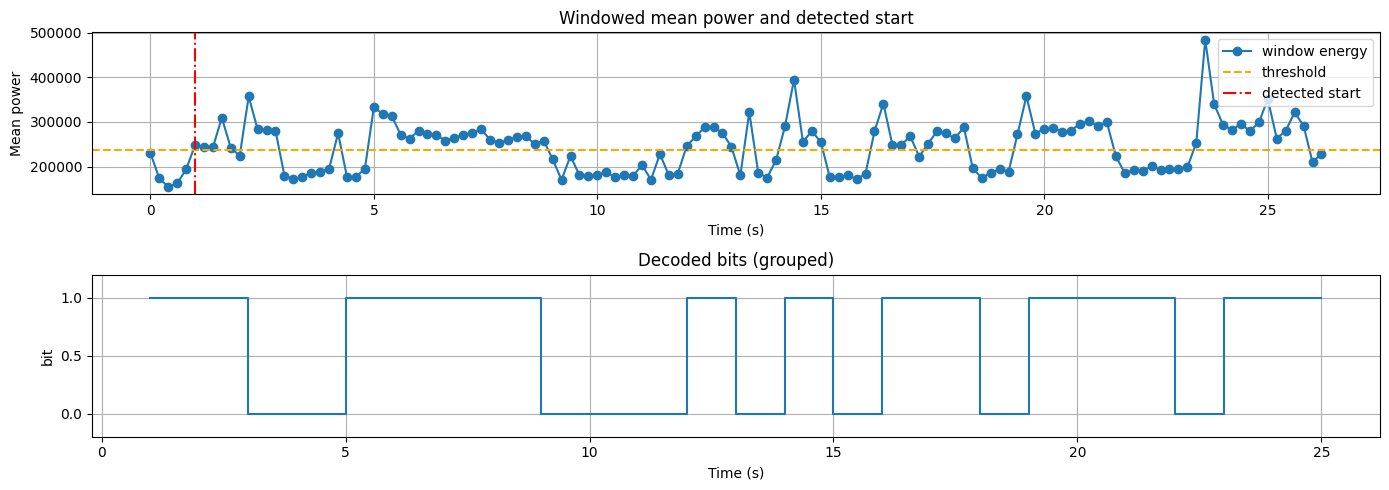

{'sr': 48000,
 'window_sec': 0.2,
 'bit_duration': 1,
 'windows_per_bit': 5,
 'energies': array([231308.18375   , 173257.701875  , 154379.560625  , 162177.49333333,
        193616.62708333, 247850.463125  , 243906.12416667, 243268.404375  ,
        309550.63708333, 241652.48666667, 224463.19833333, 357296.96395833,
        283559.63791667, 281615.80958333, 280511.468125  , 179708.745     ,
        171973.21708333, 177074.85229167, 186163.58416667, 188830.70854167,
        195544.840625  , 274525.283125  , 176346.716875  , 176537.24708333,
        195174.28333333, 332637.298125  , 318374.57041667, 314069.09645833,
        271053.12708333, 262492.26395833, 280623.2975    , 272946.53645833,
        271171.06333333, 257887.96479167, 264981.75604167, 271465.13458333,
        275708.06625   , 284099.32541667, 260318.12833333, 253719.50458333,
        258627.05520833, 267422.90770833, 267904.08645833, 250687.8025    ,
        258339.87270833, 216481.52270833, 170087.85270833, 224190.16      ,

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.ndimage import median_filter
import pandas as pd
import os

# -----------------------------
# Utility: 2-cluster threshold
# -----------------------------
def two_cluster_threshold(vals, max_iters=100, tol=1e-6):
    vals = vals.astype(float)
    c1, c2 = vals.min(), vals.max()

    for _ in range(max_iters):
        d1 = np.abs(vals - c1)
        d2 = np.abs(vals - c2)
        mask = d1 <= d2

        new_c1 = vals[mask].mean() if mask.any() else c1
        new_c2 = vals[~mask].mean() if (~mask).any() else c2

        if abs(new_c1 - c1) < tol and abs(new_c2 - c2) < tol:
            break

        c1, c2 = new_c1, new_c2

    return (c1 + c2) / 2.0, (c1, c2)


# -----------------------------
# Main decoding function with start detection and bit duration handling
# -----------------------------
def decode_energy_bits_from_wav(path,
                                window_sec=1.0,
                                bit_duration=None,
                                map_high_to=1,
                                save_prefix="decoded_bits",
                                detect_start=True,
                                min_bit_consensus=0.5,
                                smooth_runs_min_sec=0.0):
    """Декодирует биты из WAV-файла с IQ или моно-сигналом по энергии в окнах.

    Новое в этой версии:
    - параметр `bit_duration` (секунды) задаёт длительность одного бита;
    - детекция начала передачи: ищем переход 0->1 или 1->0, где смена подтверждается
      длительностью, совместимой с `bit_duration` или минимумом окон;
    - группировка окон по длительности бита и вычисление бита по голосованию (консенсус).

    Параметры:
    - path: путь к WAV
    - window_sec: длина окна, на которые усредняем энергию
    - bit_duration: ожидаемая длительность одного бита (если None — равна window_sec)
    - map_high_to: 1 если высокий уровень соответствует биту 1, иначе 0
    - detect_start: включить нахождение первого стабильного перехода
    - min_bit_consensus: доля окон в битовом интервале, необходимая для согласия (0.5 по умолчанию)
    - smooth_runs_min_sec: минимальная секунда для сглаживания коротких спайков перед детекцией
    """

    sr, data = wavfile.read(path)

    # Normalize integer WAV to [-1..1]
    # if np.issubdtype(data.dtype, np.integer):
    #     data = data.astype(np.float64) / (np.iinfo(data.dtype).max + 1)

    # Interpret channels (IQ or mono)
    if data.ndim == 1:
        complex_sig = data.astype(np.complex128)
    elif data.ndim == 2 and data.shape[1] == 2:
        complex_sig = data[:,0].astype(np.complex128) + 1j*data[:,1].astype(np.complex128)
    else:
        complex_sig = data[:,0].astype(np.complex128)

    # Instantaneous power
    power = np.abs(complex_sig)**2

    w_s = int(max(1, round(window_sec * sr)))
    n_windows = len(power) // w_s

    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    # Trim extra
    power = power[:n_windows * w_s]

    # Mean energy per window
    energies = power.reshape(n_windows, w_s).mean(axis=1)

    # Optional smoothing of energies to remove very short spikes (до группировки)
    if smooth_runs_min_sec and smooth_runs_min_sec > 0:
        min_runs = max(1, int(np.round(smooth_runs_min_sec / window_sec)))
        # простая постобработка коротких серий: если серия короче min_runs, заполнить соседним
        b = None
        # сначала бинаризуем по временному медианному порогу чтобы иметь базовые регионы
        med = np.median(energies)
        b0 = (energies >= med).astype(int)
        b = b0.copy()
        i = 0
        while i < len(b):
            j = i+1
            while j < len(b) and b[j] == b[i]:
                j += 1
            run_len = j - i
            if run_len < min_runs:
                left = b[i-1] if i>0 else None
                right = b[j] if j<len(b) else None
                if left is None and right is not None:
                    b[i:j] = right
                elif right is None and left is not None:
                    b[i:j] = left
                elif left is not None and right is not None:
                    b[i:j] = 1 if (left + right) >= 1 else 0
            i = j
        # применим маску к энергиям: сглаживаем значения серий маленькой длины как среднее соседей
        energies = energies.copy()
        i = 0
        while i < len(b):
            j = i+1
            while j < len(b) and b[j] == b[i]:
                j += 1
            run_len = j - i
            if run_len < min_runs:
                left_val = energies[i-1] if i>0 else energies[j] if j<len(b) else energies[i]
                right_val = energies[j] if j<len(b) else energies[i]
                energies[i:j] = (left_val + right_val) / 2.0
            i = j

    # Find threshold via 2 clusters
    threshold, centers = two_cluster_threshold(energies)

    # Initial raw bit decision per window
    bits_raw = (energies >= threshold).astype(int)
    # Map so that `map_high_to` corresponds to 1 in output
    if map_high_to == 0:
        bits_raw = 1 - bits_raw

    # Times of window starts
    times = np.arange(n_windows) * window_sec

    # Determine bit_duration in windows (how many windows per bit)
    if bit_duration is None:
        bit_duration = window_sec
    windows_per_bit = max(1, int(round(bit_duration / window_sec)))

    # Detect start: ищем переход, который подтверждён длительностью
    start_index = 0
    if detect_start:
        diffs = np.where(np.diff(bits_raw) != 0)[0] + 1  # candidate transition indices (window index where new value starts)
        chosen = None
        for idx in diffs:
            # длина серии справа
            j = idx
            while j < len(bits_raw) and bits_raw[j] == bits_raw[idx]:
                j += 1
            run_right = j - idx
            # длина серии слева
            i = idx-1
            while i >= 0 and bits_raw[i] == bits_raw[idx-1]:
                i -= 1
            run_left = (idx-1) - i
            # проверяем, что либо правая серия достаточна для 1 бита, либо обе стороны достаточно длинные
            if run_right >= windows_per_bit or (run_right >= max(1, windows_per_bit//2) and run_left >= max(1, windows_per_bit//2)):
                chosen = idx
                break
        if chosen is None and diffs.size > 0:
            chosen = diffs[0]
        if chosen is not None:
            start_index = chosen
        else:
            start_index = 0

    # Now group windows into bits starting at start_index
    available_windows = n_windows - start_index
    n_bits = available_windows // windows_per_bit

    decoded_bits = []
    decoded_times = []
    decoded_energies = []

    for bidx in range(n_bits):
        s = start_index + bidx*windows_per_bit
        e = s + windows_per_bit
        slice_bits = bits_raw[s:e]
        # Majority vote with consensus threshold
        val_fraction = slice_bits.mean()
        bit = 1 if val_fraction >= min_bit_consensus else 0
        decoded_bits.append(bit)
        decoded_times.append(times[s])
        decoded_energies.append(energies[s:e].mean())

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times)
    decoded_energies = np.array(decoded_energies)

    # Save results (CSV with time per decoded bit)
    df = pd.DataFrame({
        "time_start_s": decoded_times,
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"

    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    # Plot energy with detected start and per-bit decisions
    plt.figure(figsize=(14,5))
    plt.subplot(2,1,1)
    plt.title("Windowed mean power and detected start")
    plt.plot(times, energies, '-o', label='window energy')
    plt.axhline(threshold, color='orange', linestyle='--', label='threshold')
    plt.axvline(start_index*window_sec, color='red', linestyle='-.', label='detected start')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean power')
    plt.grid(True)
    plt.legend()

    plt.subplot(2,1,2)
    plt.title('Decoded bits (grouped)')
    if len(decoded_times)>0:
        plt.step(decoded_times, decoded_bits, where='post')
    plt.ylim(-0.2, 1.2)
    plt.xlabel('Time (s)')
    plt.ylabel('bit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "sr": sr,
        "window_sec": window_sec,
        "bit_duration": bit_duration,
        "windows_per_bit": windows_per_bit,
        "energies": energies,
        "threshold": threshold,
        "centers": centers,
        "start_index": start_index,
        "start_time_s": float(start_index * window_sec),
        "decoded_bits": decoded_bits,
        "csv": csv_path,
        "txt": txt_path
    }

# Пример вызова (можно изменить параметры):
decode_energy_bits_from_wav('gqrx_20251122_160910_1200000000.wav', window_sec=0.2, bit_duration=1)

# Конец ячейки


Saved CSV: decoded_bits.csv
Saved TXT: decoded_bits.txt

Decoded bits (first 200):
 1100111100010101101110111


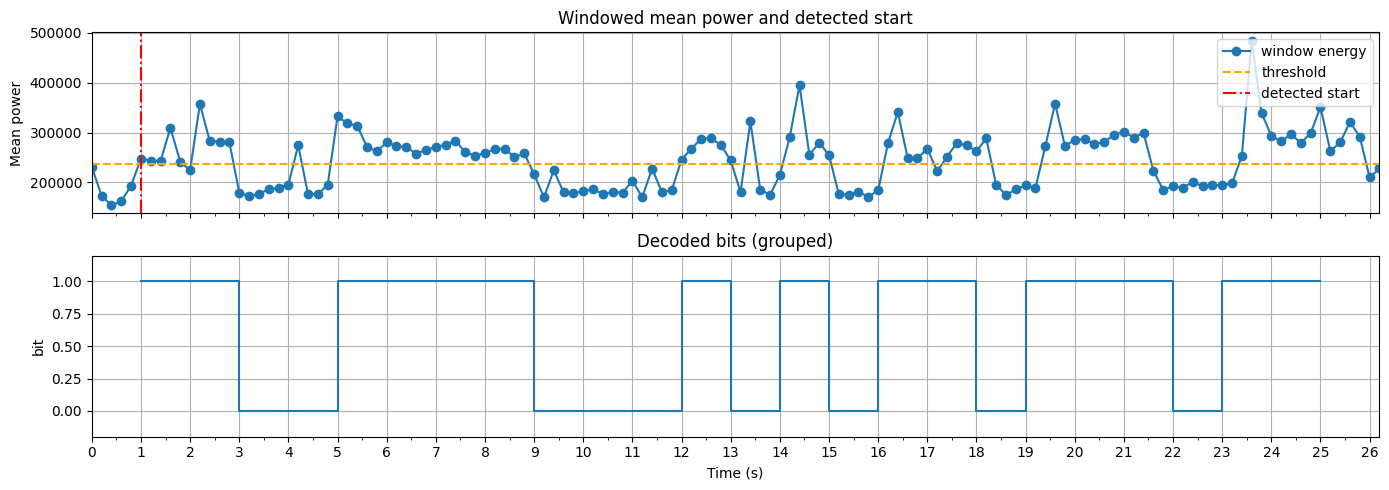

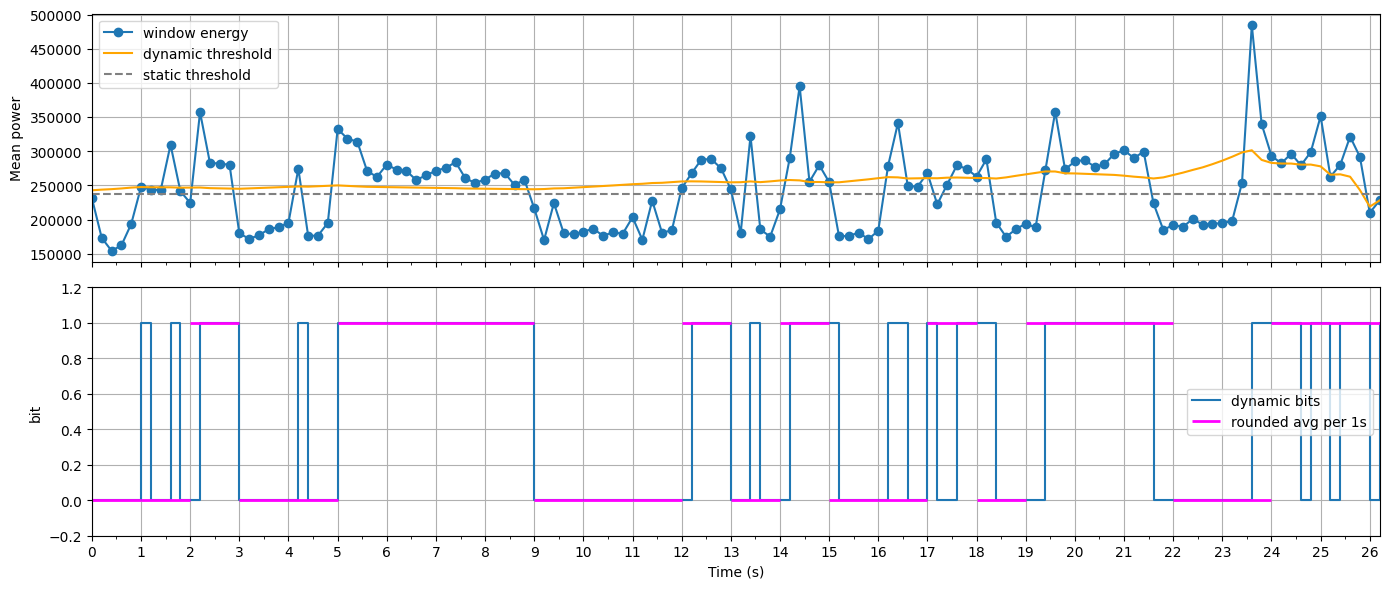

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.ndimage import median_filter
import pandas as pd
import os

# -----------------------------
# Utility: 2-cluster threshold
# -----------------------------
def two_cluster_threshold(vals, max_iters=100, tol=1e-6):
    vals = vals.astype(float)
    c1, c2 = vals.min(), vals.max()

    for _ in range(max_iters):
        d1 = np.abs(vals - c1)
        d2 = np.abs(vals - c2)
        mask = d1 <= d2

        new_c1 = vals[mask].mean() if mask.any() else c1
        new_c2 = vals[~mask].mean() if (~mask).any() else c2

        if abs(new_c1 - c1) < tol and abs(new_c2 - c2) < tol:
            break

        c1, c2 = new_c1, new_c2

    return (c1 + c2) / 2.0, (c1, c2)


# -----------------------------
# Main decoding function with start detection and bit duration handling
# -----------------------------
def decode_energy_bits_from_wav(path,
                                window_sec=1.0,
                                bit_duration=None,
                                map_high_to=1,
                                save_prefix="decoded_bits",
                                detect_start=True,
                                min_bit_consensus=0.5,
                                smooth_runs_min_sec=0.0):
    """Декодирует биты из WAV-файла с IQ или моно-сигналом по энергии в окнах.

    Новое в этой версии:
    - параметр `bit_duration` (секунды) задаёт длительность одного бита;
    - детекция начала передачи: ищем переход 0->1 или 1->0, где смена подтверждается
      длительностью, совместимой с `bit_duration` или минимумом окон;
    - группировка окон по длительности бита и вычисление бита по голосованию (консенсус).

    Параметры:
    - path: путь к WAV
    - window_sec: длина окна, на которые усредняем энергию
    - bit_duration: ожидаемая длительность одного бита (если None — равна window_sec)
    - map_high_to: 1 если высокий уровень соответствует биту 1, иначе 0
    - detect_start: включить нахождение первого стабильного перехода
    - min_bit_consensus: доля окон в битовом интервале, необходимая для согласия (0.5 по умолчанию)
    - smooth_runs_min_sec: минимальная секунда для сглаживания коротких спайков перед детекцией
    """

    sr, data = wavfile.read(path)

    # Normalize integer WAV to [-1..1]
    # if np.issubdtype(data.dtype, np.integer):
    #     data = data.astype(np.float64) / (np.iinfo(data.dtype).max + 1)

    # Interpret channels (IQ or mono)
    if data.ndim == 1:
        complex_sig = data.astype(np.complex128)
    elif data.ndim == 2 and data.shape[1] == 2:
        complex_sig = data[:,0].astype(np.complex128) + 1j*data[:,1].astype(np.complex128)
    else:
        complex_sig = data[:,0].astype(np.complex128)

    # Instantaneous power
    power = np.abs(complex_sig)**2

    w_s = int(max(1, round(window_sec * sr)))
    n_windows = len(power) // w_s

    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    # Trim extra
    power = power[:n_windows * w_s]

    # Mean energy per window
    energies = power.reshape(n_windows, w_s).mean(axis=1)

    # Optional smoothing of energies to remove very short spikes (до группировки)
    if smooth_runs_min_sec and smooth_runs_min_sec > 0:
        min_runs = max(1, int(np.round(smooth_runs_min_sec / window_sec)))
        # простая постобработка коротких серий: если серия короче min_runs, заполнить соседним
        b = None
        # сначала бинаризуем по временному медианному порогу чтобы иметь базовые регионы
        med = np.median(energies)
        b0 = (energies >= med).astype(int)
        b = b0.copy()
        i = 0
        while i < len(b):
            j = i+1
            while j < len(b) and b[j] == b[i]:
                j += 1
            run_len = j - i
            if run_len < min_runs:
                left = b[i-1] if i>0 else None
                right = b[j] if j<len(b) else None
                if left is None and right is not None:
                    b[i:j] = right
                elif right is None and left is not None:
                    b[i:j] = left
                elif left is not None and right is not None:
                    b[i:j] = 1 if (left + right) >= 1 else 0
            i = j
        # применим маску к энергиям: сглаживаем значения серий маленькой длины как среднее соседей
        energies = energies.copy()
        i = 0
        while i < len(b):
            j = i+1
            while j < len(b) and b[j] == b[i]:
                j += 1
            run_len = j - i
            if run_len < min_runs:
                left_val = energies[i-1] if i>0 else energies[j] if j<len(b) else energies[i]
                right_val = energies[j] if j<len(b) else energies[i]
                energies[i:j] = (left_val + right_val) / 2.0
            i = j

    # Find threshold via 2 clusters
    threshold, centers = two_cluster_threshold(energies)

    # Initial raw bit decision per window
    bits_raw = (energies >= threshold).astype(int)
    # Map so that `map_high_to` corresponds to 1 in output
    if map_high_to == 0:
        bits_raw = 1 - bits_raw

    # Times of window starts
    times = np.arange(n_windows) * window_sec

    # Determine bit_duration in windows (how many windows per bit)
    if bit_duration is None:
        bit_duration = window_sec
    windows_per_bit = max(1, int(round(bit_duration / window_sec)))

    # Detect start: ищем переход, который подтверждён длительностью
    start_index = 0
    if detect_start:
        diffs = np.where(np.diff(bits_raw) != 0)[0] + 1  # candidate transition indices (window index where new value starts)
        chosen = None
        for idx in diffs:
            # длина серии справа
            j = idx
            while j < len(bits_raw) and bits_raw[j] == bits_raw[idx]:
                j += 1
            run_right = j - idx
            # длина серии слева
            i = idx-1
            while i >= 0 and bits_raw[i] == bits_raw[idx-1]:
                i -= 1
            run_left = (idx-1) - i
            # проверяем, что либо правая серия достаточна для 1 бита, либо обе стороны достаточно длинные
            if run_right >= windows_per_bit or (run_right >= max(1, windows_per_bit//2) and run_left >= max(1, windows_per_bit//2)):
                chosen = idx
                break
        if chosen is None and diffs.size > 0:
            chosen = diffs[0]
        if chosen is not None:
            start_index = chosen
        else:
            start_index = 0

    # Now group windows into bits starting at start_index
    available_windows = n_windows - start_index
    n_bits = available_windows // windows_per_bit

    decoded_bits = []
    decoded_times = []
    decoded_energies = []

    for bidx in range(n_bits):
        s = start_index + bidx*windows_per_bit
        e = s + windows_per_bit
        slice_bits = bits_raw[s:e]
        # Majority vote with consensus threshold
        val_fraction = slice_bits.mean()
        bit = 1 if val_fraction >= min_bit_consensus else 0
        decoded_bits.append(bit)
        decoded_times.append(times[s])
        decoded_energies.append(energies[s:e].mean())

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times)
    decoded_energies = np.array(decoded_energies)

    # Save results (CSV with time per decoded bit)
    df = pd.DataFrame({
        "time_start_s": decoded_times,
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"

    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    # Plot energy with detected start and per-bit decisions (оси времени синхронизированы)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,5), sharex=True)
    common_xlim = (0, times[-1] if len(times) else 0)

    ax1.set_title("Windowed mean power and detected start")
    ax1.plot(times, energies, '-o', label='window energy')
    ax1.axhline(threshold, color='orange', linestyle='--', label='threshold')
    ax1.axvline(start_index*window_sec, color='red', linestyle='-.', label='detected start')
    ax1.set_ylabel('Mean power')
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    ax1.set_xlim(*common_xlim)

    ax2.set_title('Decoded bits (grouped)')
    if len(decoded_times)>0:
        ax2.step(decoded_times, decoded_bits, where='post')
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('bit')
    ax2.grid(True)
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    ax2.set_xlim(*common_xlim)
    fig.tight_layout()
    plt.show()

    return {
        "sr": sr,
        "window_sec": window_sec,
        "bit_duration": bit_duration,
        "windows_per_bit": windows_per_bit,
        "energies": energies,
        "threshold": threshold,
        "centers": centers,
        "start_index": start_index,
        "start_time_s": float(start_index * window_sec),
        "decoded_bits": decoded_bits,
        "csv": csv_path,
        "txt": txt_path
    }

# Пример вызова (можно изменить параметры):
res = decode_energy_bits_from_wav('gqrx_20251122_160910_1200000000.wav', window_sec=0.2, bit_duration=1)

# Динамический порог: среднее в скользящем 5-секундном окне по реальному времени без сглаживания.
# Для точки t=times[i] используем energies, чьи times в [t, t+window_span_sec).
def sliding_mean_threshold(times, energies, window_span_sec=5.0):
    thresholds = np.zeros(len(energies), dtype=float)
    for i, t in enumerate(times):
        mask = (times >= t) & (times < t + window_span_sec)
        window = energies[mask]
        thresholds[i] = window.mean() if len(window) else 0.0
    return thresholds

energies = res["energies"]
window_sec = res["window_sec"]
times = np.arange(len(energies)) * window_sec

dyn_threshold = sliding_mean_threshold(times, energies, window_span_sec=25.0)
dyn_bits = (energies >= dyn_threshold).astype(int)

# Среднее значение динамического бита по невзаимопересекающимся секундным интервалам
max_sec = int(np.ceil(times[-1] + window_sec)) if len(times) else 0
per_sec_times = []
per_sec_avg = []
for s in range(max_sec):
    mask = (times >= s) & (times < s + 1.0)
    if mask.any():
        per_sec_times.append(s)
        per_sec_avg.append(dyn_bits[mask].mean())
per_sec_times = np.array(per_sec_times, dtype=float)
per_sec_avg = np.array(per_sec_avg, dtype=float)


common_xlim = (0, times[-1] if len(times) else 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax1.plot(times, energies, '-o', label='window energy')
ax1.plot(times, dyn_threshold, color='orange', label='dynamic threshold')
ax1.axhline(res["threshold"], color='gray', linestyle='--', label='static threshold')
ax1.set_ylabel('Mean power')
ax1.grid(True)
ax1.legend()
ax1.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax1.set_xlim(*common_xlim)

ax2.step(times, dyn_bits, where='post', label='dynamic bits')
if len(per_sec_times):
    levels = np.where(per_sec_avg >= 0.5, 1.0, 0.0)
    ax2.hlines(levels, per_sec_times, per_sec_times + 1.0, colors='magenta', linewidth=2, label='rounded avg per 1s')
ax2.set_ylim(-0.2, 1.2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('bit')
ax2.grid(True)
ax2.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.set_xlim(*common_xlim)
ax2.legend()
fig.tight_layout()
plt.show()

# Конец ячейки
